In [1]:
import numpy as np
import pandas as pd 
import os
import cv2

TypeError: 'numpy._DTypeMeta' object is not subscriptable

# labels

In [3]:
labels = os.listdir("../input/drowsiness-dataset/train")

In [4]:
labels

['Closed', 'Open', 'yawn', 'no_yawn']

# visualize random 1 image

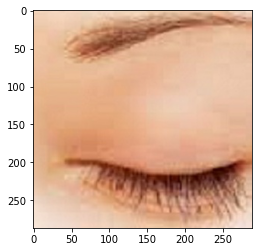

In [5]:
import matplotlib.pyplot as plt
image_close = plt.imread("../input/drowsiness-dataset/train/Closed/_100.jpg")
plt.imshow(image_close)

(300, 379, 3)

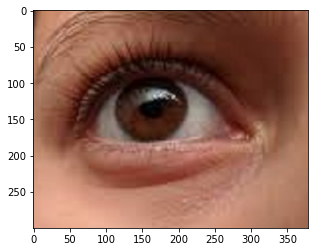

In [6]:
image_open = plt.imread("../input/drowsiness-dataset/train/Open/_100.jpg")
plt.imshow(image_open)
image_open.shape

# image array

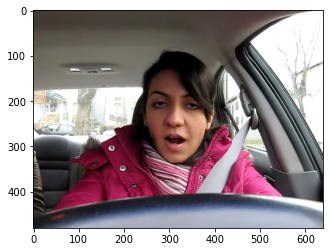

In [7]:
a = plt.imread("../input/drowsiness-dataset/train/yawn/10.jpg")
plt.imshow(a)

# image shape

In [8]:
a.shape

(480, 640, 3)

# for yawn and not_yawn. Take only face

In [9]:
def face_for_yawn(direc="../input/drowsiness-dataset/train", face_cas_path="../input/prediction-images/haarcascade_frontalface_default.xml"):
    yaw_no = [] # This is an empty list that will be used to store processed images along with their labels.
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc , category) #path to the specific category directory
        class_num1 = categories.index(category)   #Assigns a class index based on the current category
        print(class_num1 , categories[class_num1])
        
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            
            #faces = face_cascade.detectMultiScale(image_array, scaleFactor, minNeighbors) 
            #face_cascade: This is an instance of the Haar Cascade classifier, which has been previously loaded using cv2.CascadeClassifier() and is configured to detect a specific type of object (in this case, likely faces).
            #image_array: This is the image in which the Haar Cascade classifier will attempt to detect objects (faces).
            #scaleFactor: This parameter compensates for faces appearing smaller as they're found farther from the camera. It controls the reduction in size of the image at each image scale. A value of 1.3 means that the image will be scaled down by 30% at each iteration of the detection process.
            #minNeighbors: This parameter specifies how many rectangles need to be detected near the current rectangle for it to be considered a valid detection. A higher value results in fewer false positives but might miss some true detections.
            #The detectMultiScale() method returns a list of rectangles, each representing a detected object. In this context, it's used to detect faces within the image_array and returns a list of rectangles where faces are found.
            
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                #print(img)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0 yawn
1 no_yawn


# for closed and open eye

In [10]:
# def get_data(dir_path="../input/drowsiness-dataset/train/", face_cas="../input/prediction-images/haarcascade_frontalface_default.xml", eye_cas="../input/prediction-images/haarcascade.xml"):
#     labels = ['Closed', 'Open']
#     IMG_SIZE = 145
#     data = []

#     # Load Haar cascade classifiers
#     face_cascade = cv2.CascadeClassifier(face_cas)
#     eye_cascade = cv2.CascadeClassifier(eye_cas)

#     for label in labels:
#         path = os.path.join(dir_path, label)
#         class_num = labels.index(label)
#         class_num += 2
#         print(class_num)

#         for img in os.listdir(path):
#             try:
#                 img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
#                 resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
#                 data.append([resized_array, class_num])
#             except Exception as e:
#                 print(e)
#     return data

In [11]:
def get_data(dir_path="../input/drowsiness-dataset/train/", eye_cas="../input/prediction-images/haarcascade.xml"):
    IMG_SIZE = 145
    data = []
    labels = ['Closed', 'Open']
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num += 2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [12]:
data_train = get_data()


2
3


# extend data and convert array

In [13]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data) #combine 
    return np.array(yaw_no)

# new variable to store

In [14]:
new_data = append_data()

0 yawn
1 no_yawn
2
3


# separate label and features

In [15]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

# reshape the array

In [16]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

# LabelBinarizer

In [17]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

# label array

In [18]:
y = np.array(y)

# train test split

In [35]:
from sklearn.model_selection import train_test_split
seed = 40
test_size = 0.31
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

# length of X_test

In [36]:
len(X_test)

597

# Not necessary, only use to matching with my pc version

In [21]:
# !pip install tensorflow==2.3.1
# !pip install keras==2.4.3

# import some dependencies

In [29]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Data Augmentation

In [37]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [38]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 143, 143, 256)     7168      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 71, 71, 256)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 69, 69, 128)       295040    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 34, 34, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 32)       

In [39]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
42/42 [==============================] - 133s 3s/step - loss: 1.2712 - accuracy: 0.3825 - val_loss: 1.0405 - val_accuracy: 0.6700
Epoch 2/50
42/42 [==============================] - 145s 3s/step - loss: 0.6086 - accuracy: 0.7538 - val_loss: 0.4682 - val_accuracy: 0.7906
Epoch 3/50
42/42 [==============================] - 136s 3s/step - loss: 0.4472 - accuracy: 0.8012 - val_loss: 0.4045 - val_accuracy: 0.7973
Epoch 4/50
42/42 [==============================] - 133s 3s/step - loss: 0.3587 - accuracy: 0.8524 - val_loss: 0.2444 - val_accuracy: 0.9146
Epoch 5/50
42/42 [==============================] - 132s 3s/step - loss: 0.2933 - accuracy: 0.8773 - val_loss: 0.2786 - val_accuracy: 0.8978
Epoch 6/50
42/42 [==============================] - 131s 3s/step - loss: 0.2932 - accuracy: 0.8727 - val_loss: 0.1843 - val_accuracy: 0.9280
Epoch 7/50
42/42 [==============================] - 132s 3s/step - loss: 0.2648 - accuracy: 0.8908 - val_loss: 0.2752 - val_accuracy: 0.8643
Epoch 8/50
42

# history

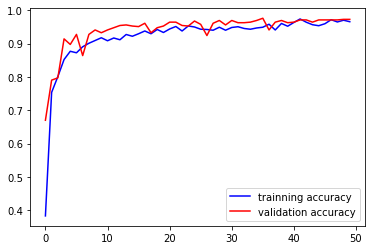

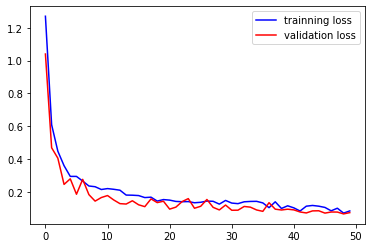

In [40]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

# save model

In [41]:
model.save("drowiness_new6.h5")

In [42]:
model.save("drowiness_new6.model")

# Prediction

In [47]:
prediction = model.predict_classes(X_test)

In [49]:
prediction

array([2, 2, 0, 2, 3, 3, 3, 3, 3, 1, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3,
       3, 0, 2, 2, 2, 1, 2, 3, 3, 2, 3, 3, 1, 2, 3, 2, 3, 2, 3, 3, 2, 2,
       3, 3, 1, 2, 2, 0, 2, 3, 3, 3, 3, 3, 2, 1, 2, 2, 1, 2, 2, 3, 2, 1,
       3, 2, 2, 2, 1, 3, 2, 3, 3, 0, 3, 0, 2, 0, 2, 1, 2, 3, 3, 3, 3, 0,
       2, 2, 3, 2, 3, 3, 3, 3, 2, 2, 0, 3, 3, 1, 3, 3, 1, 3, 0, 3, 1, 0,
       3, 1, 2, 3, 2, 3, 2, 2, 2, 2, 1, 2, 2, 1, 2, 3, 3, 2, 3, 2, 3, 2,
       3, 2, 3, 2, 2, 1, 3, 1, 1, 2, 2, 1, 3, 2, 0, 3, 2, 2, 2, 3, 3, 3,
       2, 3, 0, 2, 2, 1, 2, 3, 0, 1, 2, 3, 3, 2, 3, 3, 0, 2, 2, 3, 3, 1,
       2, 1, 2, 2, 1, 3, 3, 2, 3, 3, 2, 2, 3, 1, 1, 2, 2, 2, 2, 0, 2, 3,
       0, 0, 3, 3, 1, 2, 2, 2, 2, 1, 3, 3, 3, 3, 3, 2, 0, 3, 3, 3, 0, 2,
       0, 3, 1, 2, 3, 3, 0, 3, 0, 3, 2, 2, 2, 3, 0, 0, 3, 1, 3, 2, 2, 2,
       2, 3, 0, 3, 3, 3, 2, 3, 1, 0, 3, 2, 2, 3, 0, 2, 3, 3, 1, 1, 0, 2,
       3, 3, 3, 3, 2, 3, 1, 1, 3, 2, 3, 3, 3, 2, 2, 3, 1, 2, 1, 3, 3, 3,
       3, 3, 3, 2, 3, 1, 3, 3, 1, 3, 2, 2, 3, 1, 3,

# classification report

In [51]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [52]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.95      0.86      0.91        72
     no_yawn       0.81      0.97      0.88        77
      Closed       1.00      0.91      0.95       232
        Open       0.94      0.98      0.96       216

    accuracy                           0.94       597
   macro avg       0.92      0.93      0.92       597
weighted avg       0.95      0.94      0.94       597



# predicting function

In [53]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="../input/prediction-images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowiness_new6.h5")

# Prediction 
## 0-yawn, 1-no_yawn, 2-Closed, 3-Open

In [54]:
# prepare("../input/drowsiness-dataset/train/no_yawn/1068.jpg")
prediction = model.predict([prepare("../input/drowsiness-dataset/train/no_yawn/1067.jpg")])
np.argmax(prediction)

1

In [55]:
prediction = model.predict([prepare("../input/drowsiness-dataset/train/Closed/_101.jpg")])
np.argmax(prediction)

2

In [56]:
prediction = model.predict([prepare("../input/drowsiness-dataset/train/Open/_104.jpg")])
np.argmax(prediction)

3

In [58]:
prediction = model.predict([prepare("../input/drowsiness-dataset/train/yawn/119.jpg")])
np.argmax(prediction)

0

# If you like please upvote